In [1]:
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras import backend as K
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set GPU device
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
# Variable definition
data_folder = 'C:/Users/Jihed/Desktop/data/' # Folder containing the dataset
n_days = 1640

In [4]:
import glob
all_file=glob.glob(data_folder+"/*.csv")

In [5]:
dataset = pd.DataFrame()
assets = []
for filename in all_file:
    asset=pd.read_csv(filename, usecols=[2, 3])
    assets.append(filename.replace('.csv',''))
    asset = asset.values[:n_days]
 # Ensure all data is float
    asset = asset.astype('float32')
    dataset[filename[28:len(filename)-4]+"_var2"]=asset[:,0]
    dataset[filename[28:len(filename)-4]+"_var3"]=asset[:,1]


In [6]:
dataset

,AA_var2,AA_var3,AIG_var2,AIG_var3,AXP_var2,AXP_var3,BA_var2,BA_var3,BAC_var2,BAC_var3,...,T_var2,T_var3,UTX_var2,UTX_var3,VZ_var2,VZ_var3,WMT_var2,WMT_var3,XOM_var2,XOM_var3
0,-0.783002,3.223669,-1.050177,2.014177,0.587332,2.742718,-1.148238,2.160015,1.053650,1.443878,...,1.183446,3.738887,-0.635710,2.581862,1.372734,2.43,0.691446,1.677886,0.735204,2.71
1,0.582768,1.265373,0.331506,8.048122,1.132452,1.761822,0.855703,2.278233,-0.015884,1.952740,...,-0.321371,2.097193,1.834914,1.827509,2.857627,1.75,0.000000,1.157725,-0.477928,1.76
2,1.378214,4.439617,-0.984978,1.061641,3.287820,6.042539,1.700466,2.778914,1.165551,2.162975,...,-1.244268,2.526264,-0.288250,3.565574,0.574316,0.97,-0.069396,2.132629,0.627748,2.00
3,0.580323,1.373043,-1.102118,1.715934,-1.269858,1.175509,-0.024393,2.428592,1.036279,1.844671,...,0.924673,3.825065,-0.212669,3.120082,-0.891536,0.64,-0.174216,2.055573,-0.352823,1.91
4,-3.166492,5.618395,-1.562532,1.196191,-1.207258,2.169316,-2.886698,2.290250,-1.025979,1.573405,...,2.741370,3.163071,-1.591952,1.443682,-0.441768,0.88,0.173190,1.723431,-0.603320,1.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,-4.132043,6.559793,-8.792089,18.050007,-8.217308,14.116010,-5.061415,4.084902,-9.587065,24.325426,...,2.015673,3.907243,-2.582772,2.071874,-2.395493,2.33,-1.654369,2.839167,-0.438340,4.99
1636,0.884962,5.273685,-4.206984,30.063843,-0.477198,12.498230,1.596241,4.792752,-1.340503,36.250729,...,-0.902941,2.335344,0.970358,1.785254,-2.501209,4.03,-0.744931,3.161355,0.110382,3.19
1637,2.794345,12.724157,-12.056159,17.640764,-2.593926,9.658178,-1.678973,2.574905,-4.077930,23.770258,...,-1.700777,2.592381,-1.209880,1.723077,-1.213212,6.71,-0.817637,2.229151,-1.341311,2.64
1638,1.509691,2.435334,9.298143,26.492638,4.861025,11.374101,1.145233,1.459839,12.192448,31.552717,...,1.856429,2.088569,2.331972,1.637408,0.661621,2.14,2.217230,2.119736,0.012363,2.89


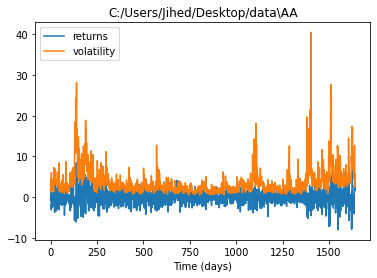

In [7]:
i = 0
plt.plot(dataset.iloc[:, 0], label='returns')
plt.plot(dataset.iloc[:, 1], label='volatility')
plt.legend()
plt.title(assets[0])
plt.xlabel('Time (days)')
plt.show()

In [8]:
dataset.shape

(1640, 58)

In [9]:
# Normalize data
factor = 2

# Calculate second raw moment
M2 = np.mean(dataset ** 2, axis=0) ** (1/2)

# Apply scaling
dataset_norm = (1/factor) * (dataset / M2)

In [10]:
M2.shape

(58,)

In [11]:
dataset.shape

(1640, 58)

In [12]:
dataset_norm.shape

(1640, 58)

In [13]:
def create_dataset(dataset, look_back=1):
    """
    Function to convert series from dataset to supervised learning problem
    """
    data_x, data_y = [], []

    for i in range(len(dataset) - look_back):

        # Create sequence of length equal to look_back
        x = dataset.iloc[i:(i + look_back), :]
        data_x.append(x)

        # Take just the volatility for the target
        data_y.append(dataset.iloc[i + look_back, 1::2])

    return np.array(data_x), np.array(data_y)

In [14]:
dataset.shape

(1640, 58)

In [38]:
look_back = 20
X, y = create_dataset(dataset_norm, look_back)

# Declare variables
n_features = dataset.shape[1]
n_assets = y.shape[1]

In [39]:
print(X.shape)
print(y.shape)
print(n_features)
print(n_assets)

(1620, 20, 58)
(1620, 29)
58
29


In [61]:
# Split dataset
training_days = 300
X_train, X_test = X[:training_days], X[training_days:]
y_train, y_test = y[:training_days], y[training_days:]

# Prepare the 3D input vector for the LSTM
X_train = np.reshape(X_train, (-1, look_back, n_features))
X_test = np.reshape(X_test, (-1, look_back, n_features))

In [62]:
X_train.shape

(300, 20, 58)

In [63]:
X_test.shape

(1320, 20, 58)

In [64]:
y_train

array([[0.34329242, 0.38781446, 0.66174823, ..., 0.29531008, 0.36252224,
        0.25306222],
       [0.41735768, 0.25981182, 0.37212834, ..., 0.28160372, 0.2848673 ,
        0.20390624],
       [0.48621178, 0.40951288, 0.69572634, ..., 0.25294492, 0.34418   ,
        0.45696846],
       ...,
       [0.40697944, 0.3990604 , 0.27130783, ..., 0.48719937, 0.32361332,
        0.20572683],
       [0.38792852, 0.15354954, 0.26545256, ..., 0.2840958 , 0.37928915,
        0.30039757],
       [0.24530081, 0.27671868, 0.3183045 , ..., 0.3713182 , 0.30671418,
        0.1948033 ]], dtype=float32)

In [65]:
y_train.shape

(300, 29)

In [66]:
X_train.shape

(300, 20, 58)

In [67]:
batch_size = 1

# Create the model
model = Sequential()
model.add(LSTM(58,
               input_shape=(look_back, n_features),
               batch_size=batch_size,
               stateful=True,
               activity_regularizer=regularizers.l1_l2(),
               recurrent_regularizer=regularizers.l1_l2()))
model.add(Dropout(0.2))
model.add(Dense(n_assets, activation='sigmoid'))          

In [68]:
# Compile the LSTM model

from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer="Adam") #rmsprop


In [69]:
num_epochs = 300

# Fit the model
for i in range(num_epochs):

    model.fit(X_train,
              y_train,
              batch_size=batch_size,
              shuffle=False,
              epochs=1,
              verbose=1) # Verbosity mode 0: silent

    #model.reset_states()

300/300 [==============================] - 3s 9ms/step - loss: 0.2570


300/300 [==============================] - 3s 9ms/step - loss: 0.2570


In [70]:
# Make a prediction (rolling test window)
y_pred = np.empty((0, n_assets))

for i in range(len(X_test)):
    X_i = X_test[i].reshape(1,look_back, n_features)
    predicted_output = model.predict(X_i, batch_size=batch_size)

    # Reshape prediction to save into array
    predicted_output = predicted_output.reshape(1, n_assets)
    y_pred = np.append(y_pred, predicted_output, axis=0)

y_pred = y_pred.reshape(-1, n_assets)
y_true = y_test.reshape(-1, n_assets)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


In [71]:
# Invert scaling
def invert_standardization(data, M2, factor):
  
    # Consider just volatility series
    M2 = M2[1::2]
    M1=list(M2)
    for i in range(len(M1)):
        data[:,i]=data[:,i]*M1[i]
        
    data = data*factor

    return data

# Apply inversion
y_pred = invert_standardization(y_pred, M2, factor)
y_true = invert_standardization(y_true, M2, factor)

In [72]:
M2.shape

(58,)

In [73]:
y_train.shape

(300, 29)

In [74]:
M1 = M2[1::2]
M1.shape

(29,)

In [75]:
y_true.shape

(1320, 29)

In [76]:
y_pred.shape

(1320, 29)

In [77]:
def evaluate(y_true, y_pred):
    """
    Function to calculate MSE and QLIKE
    """

    mse = []
    qlike = []

    for i in range(0, 29):
        mse_i = (y_true[:, i] - y_pred[:, i]) ** 2
        qlike_i = np.log(y_pred[:, i]) + (y_true[:, i] /  y_pred[:, i])

        # save results (point by point)
        results = np.array([mse_i, qlike_i]).transpose()
       
        mse.append(np.mean(mse_i, axis=0))
        qlike.append(np.mean(qlike_i, axis=0))

    return mse, qlike

In [78]:
mse, qlike = evaluate(y_true, y_pred)


In [79]:
print(mse)
print(qlike)

[6.6811874599313015, 13.919179641338774, 7.048695543549937, 6.01286972943719, 19.999715023170598, 14.459792454320674, 1.8541956531169124, 1.8763918158505084, 2.5137000467461714, 10.68702158561568, 3.5291026927890896, 53.092666955689516, 4.1716538775288, 1.3837024923112065, 9.009371129893445, 2.324203881221467, 13.793264809163492, 1.3140236825274008, 9.413554050010609, 0.8052711146643221, 9.59466716083939, 4.577304326188573, 0.4413060015195409, 0.49619703610060534, 6.418236871873163, 2.2839500407113107, 6.789410261438781, 1.4548147591119487, 1.6346493530047554]
[2.148795362248661, 1.7753860775444157, 1.5765465157457796, 1.7189757159150083, 1.347664149411826, 1.6840635210558743, 1.6659326239876904, 1.4901407644787894, 1.5039581274071983, 1.7678481906353158, 1.2914995600623447, 2.69982724507242, 1.7441152661117654, 1.1866002041943748, 2.038081767988274, 0.9921572362145853, 1.8195401590815463, 1.021572116956027, 1.891184804100792, 1.1737745170819625, 1.699529944100173, 1.5440526242452006, 

In [80]:
print(sum(mse))

217.5800994496652


In [81]:
print(sum(qlike))

44.59197679352855
